In [1]:
import psycopg2
from pyspark.sql import SparkSession


class CandidatDataLoader:
    def __init__(self, jdbc_url="jdbc:postgresql://localhost:5432/cond_db"):
        """
        Initialise la classe pour gérer les données des candidats.
        :param jdbc_url: URL de connexion JDBC à la base de données PostgreSQL.
        """
        self.jdbc_url = jdbc_url
        self.properties = {
            "user": "postgres",
            "password": "qqqqqqqqq",
            "driver": "org.postgresql.Driver"
        }

        # Requête pour créer ou remplacer la vue dans PostgreSQL
        # Requête pour créer ou remplacer la vue dans PostgreSQL
        self.create_view_query = """
        CREATE OR REPLACE VIEW sparkview_candidate_data AS
        SELECT 
            c.id AS candidate_id,
            c.full_name AS candidate_name,
            t.title_name AS title,
            COALESCE(
                (SELECT SUM(EXTRACT(YEAR FROM we.end_date) - EXTRACT(YEAR FROM we.start_date))
                 FROM work_experience_details we
                 WHERE we.candidate_id = c.id
                 GROUP BY we.candidate_id
                ), 0
            ) AS total_years_work_experience,
            COALESCE(
                (SELECT SUM(EXTRACT(YEAR FROM ed.end_date) - EXTRACT(YEAR FROM ed.start_date))
                 FROM education_details ed
                 WHERE ed.candidate_id = c.id
                 GROUP BY ed.candidate_id
                ), 0
            ) AS total_years_education,
            STRING_AGG(DISTINCT s.skill_name, ', ') AS skills,
            STRING_AGG(DISTINCT we.sector_of_activity, ', ') AS sector_of_activity,
            STRING_AGG(DISTINCT l.language_name, ', ') AS languages  -- Ignorer level_name
        FROM 
            candidates c
        LEFT JOIN 
            title t ON c.title_id = t.id
        LEFT JOIN 
            work_experience_details we ON c.id = we.candidate_id
        LEFT JOIN 
            education_details ed ON c.id = ed.candidate_id
        LEFT JOIN 
            candidate_skills cs ON c.id = cs.candidate_id
        LEFT JOIN 
            skills s ON cs.skill_id = s.id
        LEFT JOIN 
            candidate_languages cl ON c.id = cl.candidate_id
        LEFT JOIN 
            languages l ON cl.language_id = l.id
        LEFT JOIN 
            proficiency_levels pl ON cl.proficiency_level_id = pl.id
        GROUP BY 
            c.id, t.title_name
        ORDER BY 
            c.id;
        """


        # Créer la session Spark
        self.spark = SparkSession.builder \
            .appName("CandidatDataLoader") \
            .config("spark.jars.packages", "org.postgresql:postgresql:42.6.0") \
            .getOrCreate()

    def create_or_replace_view(self, host="localhost", database="cond_db", user="postgres", password="QQQQQQQQ"):
        """
        Crée ou remplace une vue dans PostgreSQL.
        :param host: Hôte de la base de données.
        :param database: Nom de la base de données.
        :param user: Utilisateur PostgreSQL.
        :param password: Mot de passe PostgreSQL.
        """
        try:
            # Établir la connexion
            conn = psycopg2.connect(host=host, database=database, user=user, password=password)
            cur = conn.cursor()

            # Créer ou remplacer la vue
            cur.execute(self.create_view_query)
            conn.commit()
            print("Vue 'sparkview_candidate_data' créée avec succès.")
        except Exception as e:
            print(f"Erreur lors de la création de la vue : {e}")
        finally:
            # Fermer la connexion
            if cur:
                cur.close()
            if conn:
                conn.close()

    def load_data(self):
        """
        Charge les données depuis PostgreSQL à l'aide de la vue créée.
        :return: DataFrame Spark contenant les données.
        """
        try:
            # Charger les données depuis la vue PostgreSQL
            df = self.spark.read.jdbc(
                url=self.jdbc_url,
                table="sparkview_candidate_data",  # Vue créée dans PostgreSQL
                properties=self.properties
            )
            print("Données chargées avec succès depuis PostgreSQL.")
            return df
        except Exception as e:
            print(f"Erreur lors du chargement des données : {e}")
            return None


In [2]:
if __name__ == "__main__":
    loader = CandidatDataLoader()

    # Étape 1 : Créer ou remplacer la vue dans PostgreSQL
    loader.create_or_replace_view()

    # Étape 2 : Charger les données dans Spark
    df_candidats = loader.load_data()

    # Afficher les premières lignes du DataFrame
    if df_candidats:
        df_candidats.show()

Vue 'sparkview_candidate_data' créée avec succès.
Données chargées avec succès depuis PostgreSQL.
+------------+--------------------+--------------------+---------------------------+---------------------+--------------------+--------------------+--------------------+
|candidate_id|      candidate_name|               title|total_years_work_experience|total_years_education|              skills|  sector_of_activity|           languages|
+------------+--------------------+--------------------+---------------------------+---------------------+--------------------+--------------------+--------------------+
|           1|Fatima Ezzahra Ka...|       Data Engineer|       0.000000000000000000| 5.000000000000000000|Drug Discovery, H...|              Mining|Arabic, English, ...|
|           2|       Hamza Malyana|      Data Scientist|       0.000000000000000000| 5.000000000000000000|Batch Processing,...|         AI Research|Arabic, English, ...|
|           3|         Ossama Hafi|        Data Anal

In [3]:
df_candidats = df_candidats.na.fill({
    "total_years_work_experience": 0,
    "total_years_education": 0,
    "title": "Unknown",
    "languages": "Unknown",
    "sector_of_activity": "Unknown"
})


In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression

#from reader_data import CandidatDataLoader


class CandidatTransformer:
    def __init__(self, df):
        """
        Initialise la classe avec un DataFrame Spark.
        :param df: DataFrame Spark contenant les données.
        """
        self.df = df

    def build_pipeline(self):
        """
        Construit un pipeline pour transformer les données.
        :return: Un objet Pipeline.
        """
        # Étape 1 : Indexation des colonnes catégoriques
        title_indexer = StringIndexer(inputCol="title", outputCol="title_indexed",handleInvalid="skip")
        langue_indexer = StringIndexer(inputCol="languages", outputCol="language_indexed",handleInvalid="skip")
        sector_indexer = StringIndexer(inputCol="sector_of_activity", outputCol="sector_indexed",handleInvalid="skip")

        # Étape 2 : Assemblage des caractéristiques
        feature_assembler = VectorAssembler(
            inputCols=["total_years_work_experience", "total_years_education", "title_indexed","language_indexed","sector_indexed"],
            outputCol="features"
        )

        # Créer un pipeline avec les étapes nécessaires
        pipeline = Pipeline(stages=[
            title_indexer,
              langue_indexer,
                  sector_indexer,
                       
            feature_assembler # Assembler les colonnes en une seule colonne 'features'
        ])

        return pipeline

    def transform(self):
        """
        Applique les transformations sur le DataFrame Spark.
        :return: DataFrame transformé.
        """
        # Construire et ajuster le pipeline
        pipeline = self.build_pipeline()
        model = pipeline.fit(self.df)

        # Appliquer les transformations
        transformed_df = model.transform(self.df)
        return transformed_df

# Exemple d'utilisation
if __name__ == "__main__":
    
    loader = CandidatDataLoader()
    df_candidats = loader.load_data()
    
   

    # Instancier la classe avec le DataFrame
    transformer = CandidatTransformer(df_candidats)

    # Appliquer les transformations
    result_df = transformer.transform()

    # Afficher les colonnes transformées
    result_df.select("features").show()


Données chargées avec succès depuis PostgreSQL.
+--------------------+
|            features|
+--------------------+
|[0.0,5.0,2.0,27.0...|
|[0.0,5.0,8.0,30.0...|
|[0.0,5.0,4.0,9.0,...|
|[0.0,5.0,0.0,12.0...|
|[1.0,5.0,8.0,27.0...|
|[2.0,3.0,8.0,11.0...|
|[0.0,2.0,2.0,17.0...|
|[1.0,2.0,4.0,17.0...|
|[3.0,3.0,0.0,19.0...|
|[0.0,2.0,8.0,20.0...|
|[0.0,5.0,2.0,7.0,...|
|[2.0,3.0,4.0,0.0,...|
|[0.0,2.0,0.0,17.0...|
|[0.0,3.0,2.0,2.0,...|
|[0.0,3.0,8.0,0.0,...|
|[2.0,2.0,4.0,20.0...|
|[0.0,2.0,0.0,8.0,...|
|[0.0,3.0,2.0,7.0,...|
|[3.0,2.0,8.0,8.0,...|
|[0.0,5.0,0.0,1.0,...|
+--------------------+
only showing top 20 rows



In [5]:
result_df.show()

+------------+--------------------+--------------------+---------------------------+---------------------+--------------------+--------------------+--------------------+-------------+----------------+--------------+--------------------+
|candidate_id|      candidate_name|               title|total_years_work_experience|total_years_education|              skills|  sector_of_activity|           languages|title_indexed|language_indexed|sector_indexed|            features|
+------------+--------------------+--------------------+---------------------------+---------------------+--------------------+--------------------+--------------------+-------------+----------------+--------------+--------------------+
|           1|Fatima Ezzahra Ka...|       Data Engineer|       0.000000000000000000| 5.000000000000000000|Drug Discovery, H...|              Mining|Arabic, English, ...|          2.0|            27.0|          69.0|[0.0,5.0,2.0,27.0...|
|           2|       Hamza Malyana|      Data Scient

Données chargées avec succès depuis PostgreSQL.
Résultats après segmentation :
+--------------------+-------+
|        pca_features|cluster|
+--------------------+-------+
|[-30.616244362658...|      1|
|[-31.746760917515...|      1|
|[-11.366368913978...|      1|
|[-13.733481064812...|      1|
|[-28.700407173478...|      1|
|[-11.717885634215...|      2|
|[-20.735191408317...|      1|
|[-20.310124801803...|      1|
|[-19.299467642570...|      0|
|[-20.647035414327...|      0|
+--------------------+-------+
only showing top 10 rows



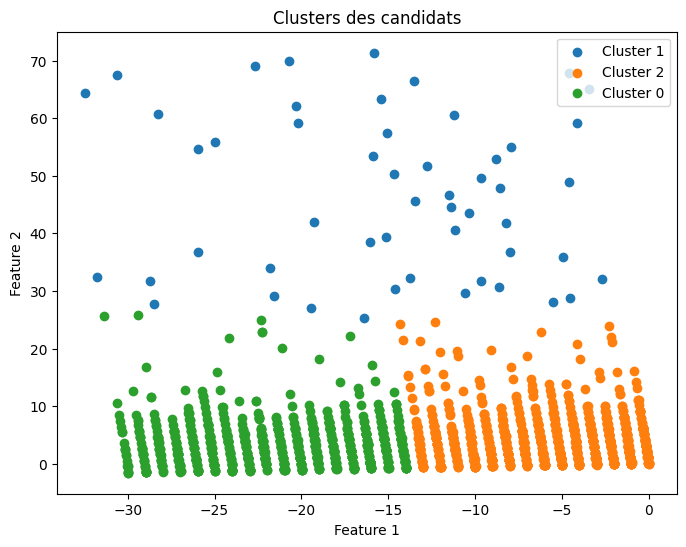

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
#from reader_data import CandidatDataLoader
#from transformer import CandidatTransformer
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import PCA

class CandidatSegmentation:
    def __init__(self, df, k=3, seed=42):
        """
        Initialise la classe pour la segmentation des candidats.
        :param df: DataFrame Spark contenant les données transformées.
        :param k: Nombre de clusters pour KMeans.
        :param seed: Seed pour la reproductibilité.
        """
        self.df = df
        self.k = k
        self.seed = seed

    def segment(self):
        """
        Applique la segmentation KMeans sur le DataFrame.
        :return: DataFrame avec une colonne supplémentaire "cluster" représentant les clusters.
        """
        # Configurer le modèle KMeans
        kmeans = KMeans(k=self.k, seed=self.seed, featuresCol="features", predictionCol="cluster")

        # Ajuster le modèle
        model = kmeans.fit(self.df)

        # Appliquer la segmentation et ajouter les prédictions au DataFrame
        df_clustered = model.transform(self.df)

        return df_clustered


# Exemple d'utilisation
if __name__ == "__main__":
   
    # Charger les données
    loader = CandidatDataLoader()
    df_candidats = loader.load_data()
    
    # Appliquer les transformations
    transformer = CandidatTransformer(df_candidats)
    result_df = transformer.transform()

    # Appliquer PCA pour réduire les dimensions à 2
    pca = PCA(k=2, inputCol="features", outputCol="pca_features")
    pca_model = pca.fit(result_df)
    result_df_pca = pca_model.transform(result_df)

    # Appliquer la segmentation KMeans
    segmenter = CandidatSegmentation(result_df_pca, k=3)
    clustered_df = segmenter.segment()

    # Afficher les résultats de la segmentation
    print("Résultats après segmentation :")
    clustered_df.select("pca_features", "cluster").show(10)

    # Pour visualiser les résultats, convertir en Pandas
    clustered_pandas = clustered_df.select("pca_features", "cluster").toPandas()

    # Extraire les features réduites par PCA pour les visualiser
    features = clustered_pandas["pca_features"].apply(lambda x: list(x)).tolist()
    clusters = clustered_pandas["cluster"].tolist()

    # Convertir les features en DataFrame pour visualisation
    features_df = pd.DataFrame(features, columns=["Feature1", "Feature2"])
    features_df["Cluster"] = clusters

    # Visualisation des clusters
    plt.figure(figsize=(8, 6))
    for cluster in features_df["Cluster"].unique():
        cluster_data = features_df[features_df["Cluster"] == cluster]
        plt.scatter(cluster_data["Feature1"], cluster_data["Feature2"], label=f"Cluster {cluster}")
    
    plt.title("Clusters des candidats")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()


In [7]:
# Créer un DataFrame contenant uniquement candidate_id et cluster
df_candidate_clusters = clustered_df.select("candidate_id", "cluster")

# Afficher les résultats
print("DataFrame contenant les candidats et leurs clusters :")
df_candidate_clusters.show()


DataFrame contenant les candidats et leurs clusters :
+------------+-------+
|candidate_id|cluster|
+------------+-------+
|           1|      1|
|           2|      1|
|           3|      1|
|           4|      1|
|           5|      1|
|           6|      2|
|           7|      1|
|           8|      1|
|           9|      0|
|          10|      0|
|          11|      2|
|          12|      2|
|          13|      1|
|          14|      2|
|          15|      2|
|          16|      0|
|          17|      2|
|          18|      2|
|          19|      1|
|          20|      1|
+------------+-------+
only showing top 20 rows



In [9]:
# # Extraire les IDs manquants
# missing_candidates = df_candidats.select("candidate_id").subtract(df_candidate_clusters.select("candidate_id"))

# # Afficher les candidats manquants
# print("Candidats manquants :")
# missing_candidates.show()


In [10]:
# Convertir en DataFrame Pandas
result_pandas = df_candidate_clusters.toPandas()

# Sauvegarder en CSV avec Pandas
result_pandas.to_csv("segmentation_Results.csv", index=False)

print("Le fichier CSV a été exporté avec succès : segmentation_Results.csv")

Le fichier CSV a été exporté avec succès : segmentation_Results.csv


In [11]:
from pyspark.sql.functions import avg

In [13]:
# Moyennes par cluster
df_summary = clustered_df.groupBy("cluster").agg(
    avg("total_years_work_experience").alias("avg_work_experience"),
    avg("total_years_education").alias("avg_education")
)

# Afficher les moyennes
df_summary.show()

+-------+--------------------+--------------------+
|cluster| avg_work_experience|       avg_education|
+-------+--------------------+--------------------+
|      1|3.038461538461538...|3.173076923076923...|
|      2|1.688090737240075...|2.906427221172022...|
|      0|1.685339690107270...|2.876042908224076...|
+-------+--------------------+--------------------+



In [16]:
df_clusters = clustered_df

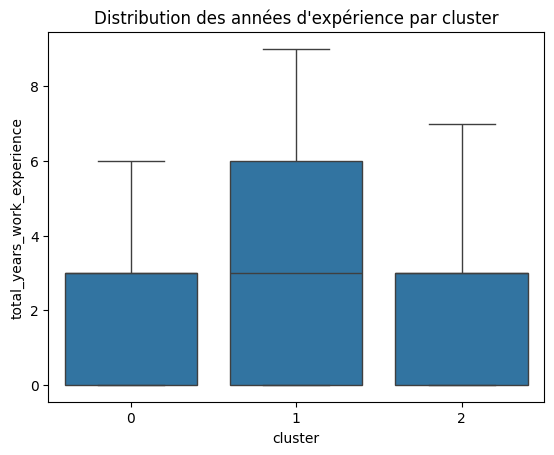

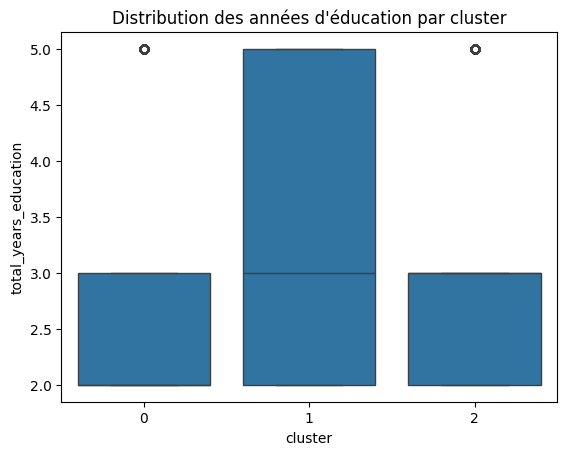

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir en Pandas pour visualisation
df_clusters_pd = df_clusters.toPandas()

# Visualisation des distributions
sns.boxplot(data=df_clusters_pd, x="cluster", y="total_years_work_experience")
plt.title("Distribution des années d'expérience par cluster")
plt.show()

sns.boxplot(data=df_clusters_pd, x="cluster", y="total_years_education")
plt.title("Distribution des années d'éducation par cluster")
plt.show()


In [18]:
from pyspark.sql.functions import mean, stddev, min, max, expr

# Statistiques descriptives par cluster
df_cluster_stats = df_clusters.groupBy("cluster").agg(
    mean("total_years_work_experience").alias("mean_work_experience"),
    stddev("total_years_work_experience").alias("stddev_work_experience"),
    min("total_years_work_experience").alias("min_work_experience"),
    max("total_years_work_experience").alias("max_work_experience"),
    mean("total_years_education").alias("mean_education"),
    stddev("total_years_education").alias("stddev_education"),
    min("total_years_education").alias("min_education"),
    max("total_years_education").alias("max_education")
)

# Afficher les statistiques
df_cluster_stats.show()

+-------+--------------------+----------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+
|cluster|mean_work_experience|stddev_work_experience| min_work_experience| max_work_experience|      mean_education|  stddev_education|       min_education|       max_education|
+-------+--------------------+----------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+
|      1|3.038461538461538...|    2.8898845791561723|0.000000000000000000|9.000000000000000000|3.173076923076923...| 1.263688250308128|2.000000000000000000|5.000000000000000000|
|      2|1.688090737240075...|    1.6889282577087343|0.000000000000000000|7.000000000000000000|2.906427221172022...|1.1400245208470208|2.000000000000000000|5.000000000000000000|
|      0|1.685339690107270...|    1.6848792929252565|0.000000000000000000|6.000000000000000000|2.8760429082240

In [19]:
from pyspark.sql.functions import col, count

# Catégories les plus fréquentes dans chaque cluster
df_title_distribution = df_clusters.groupBy("cluster", "title").count().orderBy("cluster", col("count").desc())
df_title_distribution.show()

df_language_distribution = df_clusters.groupBy("cluster", "languages").count().orderBy("cluster", col("count").desc())
df_language_distribution.show()

df_sector_distribution = df_clusters.groupBy("cluster", "sector_of_activity").count().orderBy("cluster", col("count").desc())
df_sector_distribution.show()


+-------+--------------------+-----+
|cluster|               title|count|
+-------+--------------------+-----+
|      0|Machine Learning ...|  162|
|      0|   Software Engineer|  161|
|      0|       Data Engineer|  120|
|      0|Blockchain Developer|  115|
|      0|        Data Analyst|  101|
|      0|     Cloud Architect|   68|
|      0|Business Intellig...|   41|
|      0|Full Stack Developer|   34|
|      0|Artificial Intell...|    8|
|      0|      Data Architect|    7|
|      0|     DevOps Engineer|    5|
|      0|      Data Scientist|    5|
|      0|Data Visualizatio...|    3|
|      0|     Product Manager|    2|
|      0|Cybersecurity Ana...|    2|
|      0|   Big Data Engineer|    2|
|      0|Database Administ...|    2|
|      0|Machine Learning ...|    1|
|      1|Machine Learning ...|   13|
|      1|       Data Engineer|    8|
+-------+--------------------+-----+
only showing top 20 rows

+-------+--------------------+-----+
|cluster|           languages|count|
+-------+---

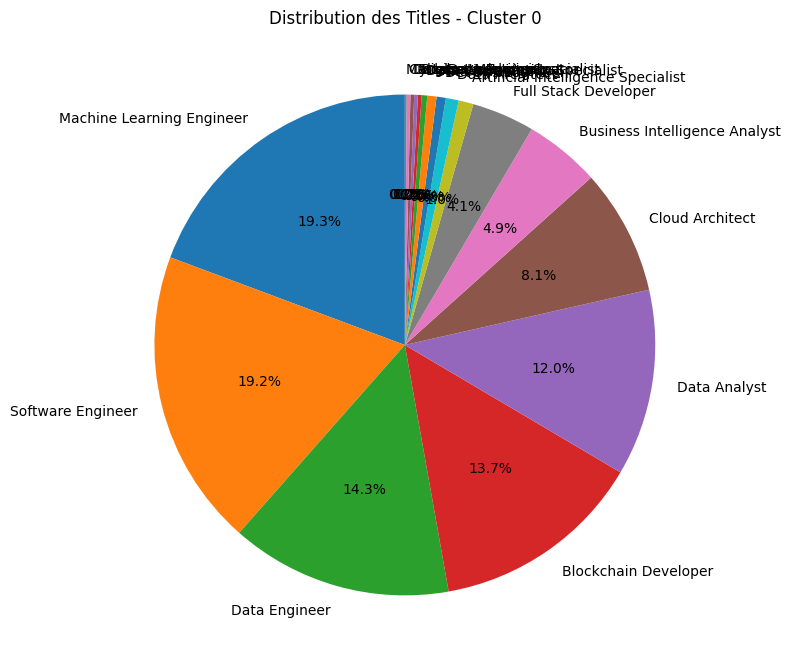

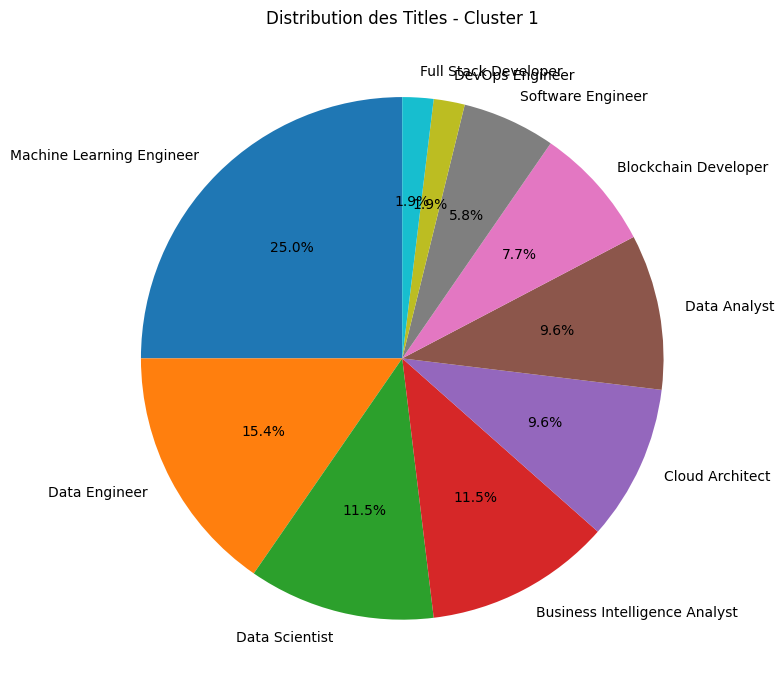

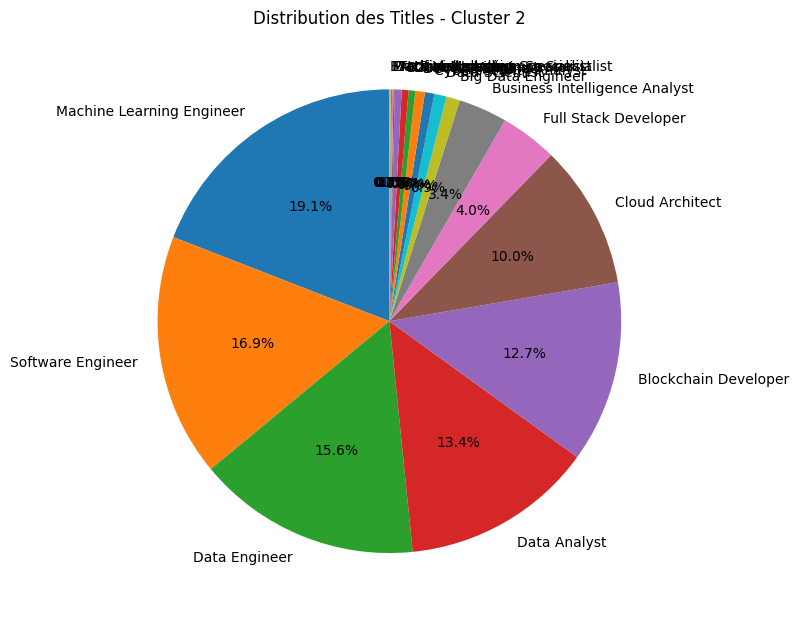

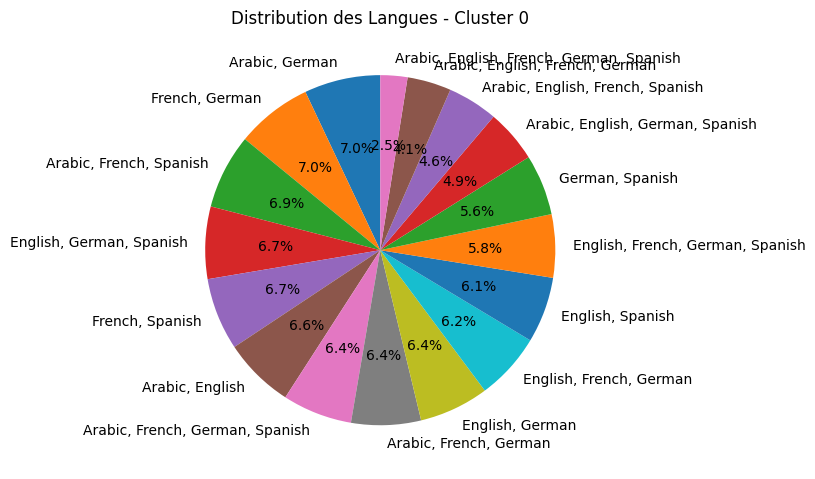

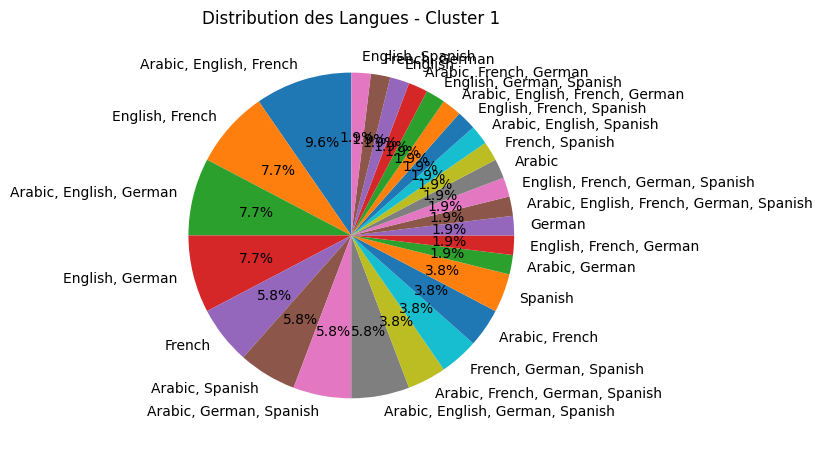

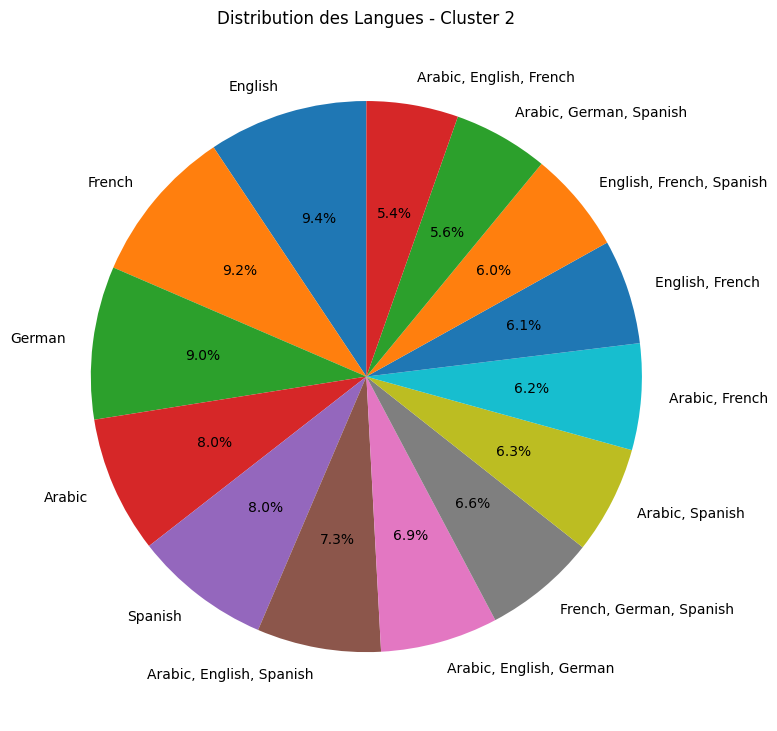

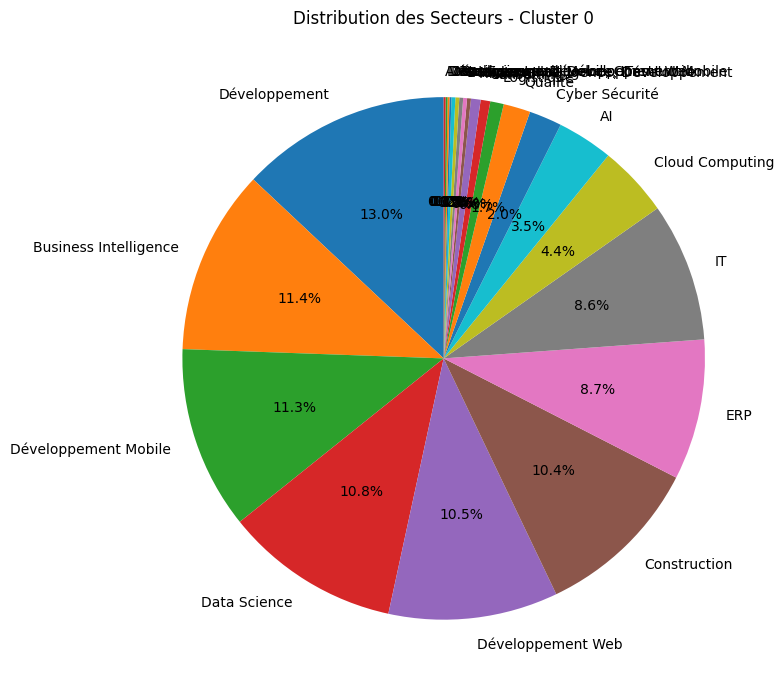

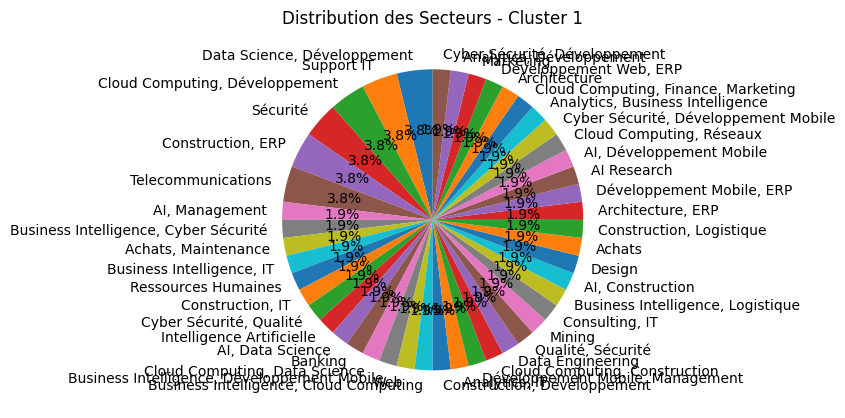

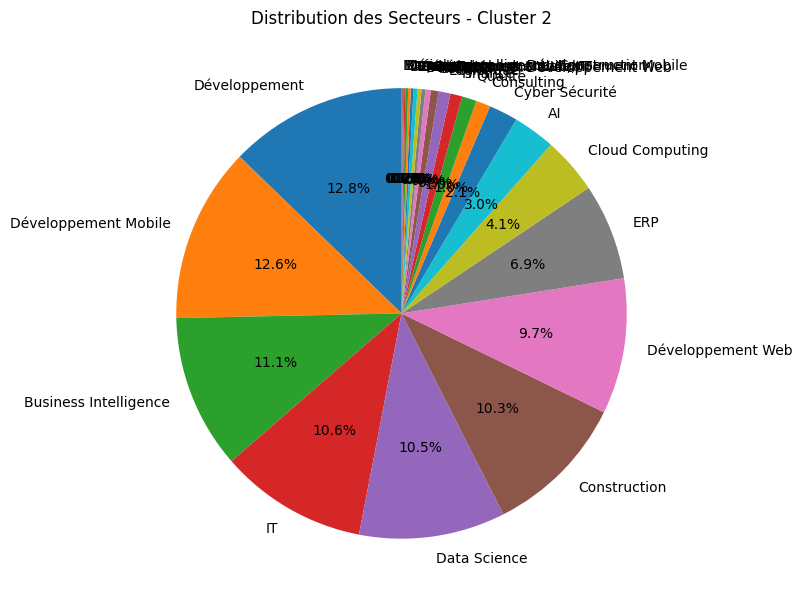

{'Title Distribution CSV': 'title_distribution.csv',
 'Language Distribution CSV': 'language_distribution.csv',
 'Sector Distribution CSV': 'sector_distribution.csv'}

In [20]:
# Exporter chaque DataFrame dans un fichier CSV et créer des diagrammes circulaires

import matplotlib.pyplot as plt

# Exporter df_title_distribution dans un fichier CSV
df_title_distribution_pd = df_title_distribution.toPandas()
df_title_distribution_csv_path = 'title_distribution.csv'
df_title_distribution_pd.to_csv(df_title_distribution_csv_path, index=False)

# Exporter df_language_distribution dans un fichier CSV
df_language_distribution_pd = df_language_distribution.toPandas()
df_language_distribution_csv_path = 'language_distribution.csv'
df_language_distribution_pd.to_csv(df_language_distribution_csv_path, index=False)

# Exporter df_sector_distribution dans un fichier CSV
df_sector_distribution_pd = df_sector_distribution.toPandas()
df_sector_distribution_csv_path = 'sector_distribution.csv'
df_sector_distribution_pd.to_csv(df_sector_distribution_csv_path, index=False)

# Créer des diagrammes circulaires pour chaque cluster
def plot_pie_charts(df, column_name, cluster_column, title_prefix):
    clusters = df[cluster_column].unique()
    for cluster in clusters:
        # Filtrer les données pour le cluster actuel
        cluster_data = df[df[cluster_column] == cluster]
        
        # Créer le diagramme circulaire
        plt.figure(figsize=(8, 8))
        plt.pie(
            cluster_data["count"],
            labels=cluster_data[column_name],
            autopct='%1.1f%%',
            startangle=90
        )
        plt.title(f"{title_prefix} - Cluster {cluster}")
        plt.tight_layout()
        plt.show()

# Créer les diagrammes pour df_title_distribution
plot_pie_charts(df_title_distribution_pd, "title", "cluster", "Distribution des Titles")

# Créer les diagrammes pour df_language_distribution
plot_pie_charts(df_language_distribution_pd, "languages", "cluster", "Distribution des Langues")

# Créer les diagrammes pour df_sector_distribution
plot_pie_charts(df_sector_distribution_pd, "sector_of_activity", "cluster", "Distribution des Secteurs")

# Retourner les chemins des fichiers CSV
{
    "Title Distribution CSV": df_title_distribution_csv_path,
    "Language Distribution CSV": df_language_distribution_csv_path,
    "Sector Distribution CSV": df_sector_distribution_csv_path
}


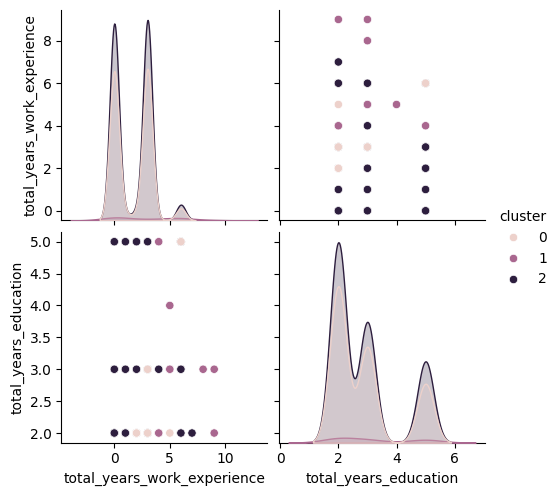

In [21]:
# Créer un DataFrame Pandas
df_clusters_pd = df_clusters.toPandas()

# Visualisation avec pairplot
sns.pairplot(df_clusters_pd, hue="cluster", vars=["total_years_work_experience", "total_years_education"])
plt.show()


In [22]:
df_clusters_pd

,candidate_id,candidate_name,title,total_years_work_experience,total_years_education,skills,sector_of_activity,languages,title_indexed,language_indexed,sector_indexed,features,pca_features,cluster
0,1,Fatima Ezzahra Kadiri,Data Engineer,0E-18,5.000000000000000000,"Drug Discovery, HIPAA Compliance, Java, LSTM N...",Mining,"Arabic, English, German, Spanish",2.0,27.0,69.0,"[0.0, 5.0, 2.0, 27.0, 69.0]","[-30.616244362658747, 67.49719021248333]",1
1,2,Hamza Malyana,Data Scientist,0E-18,5.000000000000000000,"Batch Processing, Cassandra, Data Pipeline Aut...",AI Research,"Arabic, English, French, German, Spanish",8.0,30.0,34.0,"[0.0, 5.0, 8.0, 30.0, 34.0]","[-31.746760917515477, 32.488723606902596]",1
2,3,Ossama Hafi,Data Analyst,0E-18,5.000000000000000000,"AIOps, Campaign Optimization, Geospatial Analy...",Banking,"English, French",4.0,9.0,45.0,"[0.0, 5.0, 4.0, 9.0, 45.0]","[-11.366368913978894, 44.52494887741126]",1
3,4,Said Khalid,Machine Learning Engineer,0E-18,5.000000000000000000,"Agile Methodologies, Business Intelligence, Cl...",Telecommunications,"Arabic, English, French",0.0,12.0,33.0,"[0.0, 5.0, 0.0, 12.0, 33.0]","[-13.733481064812603, 32.332955369623505]",1
4,5,Sara El Yousfi,Data Scientist,1.000000000000000000,5.000000000000000000,"Data Engineering, Data Ethics, DBSCAN, Hierarc...",Telecommunications,"Arabic, English, German, Spanish",8.0,27.0,33.0,"[1.0, 5.0, 8.0, 27.0, 33.0]","[-28.700407173478595, 31.677299969779675]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,1946,Nisrine Raguib,Software Engineer,0E-18,2.000000000000000000,"ARIMA Models, Cloud Computing, Deep Learning, ...",Développement,"Arabic, German, Spanish",1.0,13.0,0.0,"[0.0, 2.0, 1.0, 13.0, 0.0]","[-12.98063175663238, -0.6623063144829148]",2
1945,1947,FATIMA ZAHRA DYANE,Blockchain Developer,3.000000000000000000,5.000000000000000000,"Angular.js, Autoencoders, Data Preprocessing, ...",ERP,Arabic,3.0,4.0,7.0,"[3.0, 5.0, 3.0, 4.0, 7.0]","[-4.3689610656831315, 6.931440934252401]",2
1946,1948,Mohamed Asslaoui,Data Analyst,0E-18,3.000000000000000000,"AWS, Data Cleaning, Data Pipeline Automation, ...",IT,Arabic,4.0,4.0,6.0,"[0.0, 3.0, 4.0, 4.0, 6.0]","[-4.306225663631616, 5.851566328335874]",2
1947,1949,ANISSA ZAHEUR,Software Engineer,0E-18,2.000000000000000000,"A/B Testing, APIs Development, AR/VR Developme...",Business Intelligence,"Arabic, Spanish",1.0,8.0,2.0,"[0.0, 2.0, 1.0, 8.0, 2.0]","[-8.0936498027821, 1.598896127051897]",2


In [25]:
#df_clusters_pd = df_clusters_pd.toPandas()
df_clusters_pd_csv_path = 'df_clusters_pd.csv'
df_clusters_pd.to_csv(df_clusters_pd_csv_path, index=False)

In [ ]:
import pandas as pd

# Suppression des colonnes de df_clusters_pd
df = df_clusters_pd.drop(columns=['total_years_work_experience', 'total_years_education'])


In [ ]:
from pyspark.sql import SparkSession

# Créer une session Spark (si ce n'est pas déjà fait)
spark = SparkSession.builder.appName("PandasToSpark").getOrCreate()

 
# Convertir le DataFrame pandas en DataFrame Spark
df_spark = spark.createDataFrame(df)

# Afficher le schéma du DataFrame Spark
df_spark.printSchema()

# Afficher les données
df_spark.show()

In [ ]:
df_candidats

In [ ]:
# Joindre les colonnes extraites au DataFrame Spark principal
df_spark = df_spark.join(
    df_candidats.select('candidate_id', 'total_years_work_experience', 'total_years_education'),
    on='candidate_id',  # Utilisez la clé appropriée pour la jointure
    how='left'
)

# Afficher les résultats
df_spark.show()


In [ ]:
from pyspark.sql import SparkSession

# Créer une session Spark
spark = SparkSession.builder \
    .appName("Export to PostgreSQL") \
    .config("spark.jars", "/chemin/vers/postgresql-42.6.0.jar") \
    .getOrCreate()

# Sélection des colonnes spécifiques
df_selected = df_spark.select("candidate_id", "cluster", "total_years_work_experience", "total_years_education")

# Informations de connexion PostgreSQL
database_url = "jdbc:postgresql://localhost:5432/cond_db"
database_properties = {
    "user": "postgres",
    "password": "qqqqqqqq",
    "driver": "org.postgresql.Driver"
}

# Exporter le DataFrame vers PostgreSQL
df_selected.write.jdbc(
    url=database_url,
    table="my_table",
    mode="overwrite",
    properties=database_properties
)